In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from utils.preprocessing import SlidingWindowCV
from utils.analysis import check_distribution_shift, analyze_correlation_drift
from utils.metrics import pf_scorer, perf_stats_from_logrets
from utils.helpers import round_sigfig_df, get_preprocessed_feature_names
from utils.plotting import *
from scipy.stats import loguniform, uniform
import numpy as np
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [80]:
df = pd.read_csv('../data/full-dataset/full-dataset.csv')

In [81]:
df.drop(columns=['qqq_Close', 'qqq_closing_bid', 'qqq_closing_ask',
                 'gld_Close', 'gbpusd_Close', 'usdjpy_Close',
                 't2y_DGS2'], inplace=True)
df.drop(columns=['qqq_fwd_ret_label_1'], inplace=True)

df.dropna(inplace=True)
df.set_index('Date', inplace=True)

Pipeline and model construction

In [82]:
X = df.drop(columns=['qqq_fwd_ret_1'])
X.index = pd.to_datetime(X.index)
y = df['qqq_fwd_ret_1']
y.index = pd.to_datetime(y.index)

In [83]:
models = []
models.append(('EN', ElasticNet()))
models.append(('GBM', GradientBoostingRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('XGB', XGBRegressor()))

In [84]:
cols_to_scale = X.columns.difference(['qqq_weekday', 'qqq_month'])

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), cols_to_scale),
    ],
    remainder="passthrough"
)

cv = SlidingWindowCV(train_size=1000, test_size=100)

In [85]:
#Rough model comparision, without hyperparameter tuning, using pipeline to combine preprocessing and model training
results = {'EN': [], 'GBM': [], 'RF': [], 'XGB': []}

for model in models:
    print(f"Evaluating model: {model[0]}")
    pipeline = Pipeline([("preprocess", preprocess), ("model", model[1])])
    for fold_id, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]
        
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred = pipeline.predict(X_val_fold)
        score_train = pf_scorer(y_train_fold, pipeline.predict(X_train_fold))
        score_val = pf_scorer(y_val_fold, y_pred)
        results[model[0]].append((score_train, score_val))
        print(f"Fold {fold_id + 1}  PF Score training: {score_train:.4f}, PF Score validation: {score_val:.4f}")

Evaluating model: EN
Fold 1  PF Score training: 1.1804, PF Score validation: 0.9041
Fold 2  PF Score training: 1.1292, PF Score validation: 1.0107
Fold 3  PF Score training: 1.0907, PF Score validation: 0.8448
Fold 4  PF Score training: 1.0479, PF Score validation: 1.0424
Fold 5  PF Score training: 1.0532, PF Score validation: 1.8338
Fold 6  PF Score training: 1.1836, PF Score validation: 1.2327
Fold 7  PF Score training: 1.1892, PF Score validation: 1.4810
Fold 8  PF Score training: 1.2008, PF Score validation: 1.0206
Fold 9  PF Score training: 1.1660, PF Score validation: 0.7695
Fold 10  PF Score training: 1.0876, PF Score validation: 0.8962
Fold 11  PF Score training: 1.0629, PF Score validation: 2.0088
Fold 12  PF Score training: 1.1319, PF Score validation: 1.1491
Fold 13  PF Score training: 1.1450, PF Score validation: 1.2160
Fold 14  PF Score training: 1.1759, PF Score validation: 1.1469
Evaluating model: GBM
Fold 1  PF Score training: 9.5633, PF Score validation: 1.0836
Fold 2 

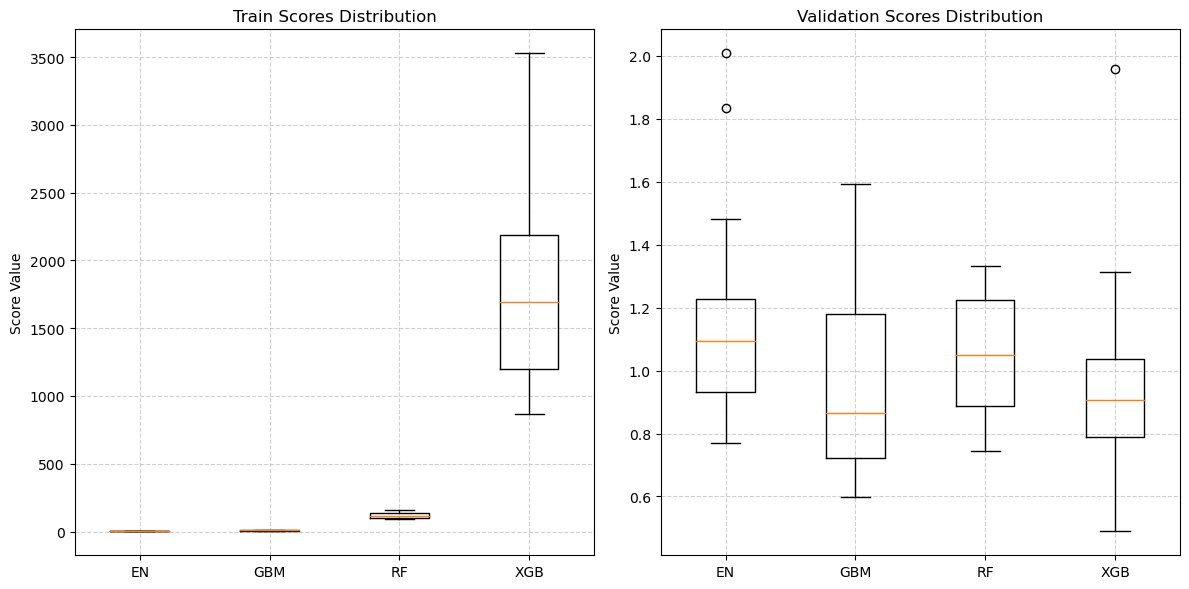

  Model  Mean Train Score  Mean Val Score
0    EN          1.131736        1.182596
1   GBM          7.942680        0.947862
2    RF        118.756431        1.046824
3   XGB       1817.526666        0.978750


In [86]:
# 1. Separate the first elements (Train) and second elements (Validation)
train_data = {model: [t[0] for t in scores] for model, scores in results.items()}
val_data = {model: [t[1] for t in scores] for model, scores in results.items()}

# 2. Setup the visualization (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Train Scores
axes[0].boxplot(train_data.values(), labels=train_data.keys())
axes[0].set_title('Train Scores Distribution')
axes[0].set_ylabel('Score Value')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot Validation Scores
axes[1].boxplot(val_data.values(), labels=val_data.keys())
axes[1].set_title('Validation Scores Distribution')
axes[1].set_ylabel('Score Value')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 3. Calculate and print summary statistics
summary_list = []
for model in results:
    train_mean = sum(train_data[model]) / len(train_data[model])
    val_mean = sum(val_data[model]) / len(val_data[model])
    summary_list.append({
        'Model': model,
        'Mean Train Score': train_mean,
        'Mean Val Score': val_mean
    })

summary_df = pd.DataFrame(summary_list)
print(summary_df)

The ElasticNet (EN) model is currently the most reliable choice. In environments with high noise, simpler linear models with regularization often outperform complex non-linear models because they are less likely to chase random fluctuations.

Walk Forward Testing

In [87]:
np.random.seed(42)

pg = []
for _ in range(30):
    pg.append({
        "model__alpha": loguniform.rvs(1e-5, 1),
        "model__l1_ratio": uniform.rvs(0, 0.5)
    })

# --- store results here ---
cv_res = {}
oof_pred = pd.Series(index=X.index, dtype=float)
oof_pos  = pd.Series(index=X.index, dtype=int)
model = ElasticNet()

for fold_id, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    best_train = -np.inf
    best_params = None

    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_val_fold, y_val_fold     = X.iloc[val_idx], y.iloc[val_idx]

    # --- select best params on TRAIN (per fold) ---
    for param in pg:
        pipeline = Pipeline([("preprocess", preprocess), ("model", model)])
        pipeline.set_params(**param)

        pipeline.fit(X_train_fold, y_train_fold)
        score_train = pf_scorer(
            y_train_fold,
            pipeline.predict(X_train_fold)
        )

        if score_train > best_train:
            best_train = score_train
            best_params = param

    # --- refit best on TRAIN, evaluate on VAL ---
    pipeline = Pipeline([("preprocess", preprocess), ("model", model)])
    pipeline.set_params(**best_params)
    pipeline.fit(X_train_fold, y_train_fold)

    y_pred = pipeline.predict(X_val_fold)
    score_val = pf_scorer(y_val_fold, y_pred)

    # position: 1 / -1 / 0 by threshold
    pos_val = np.where(
        y_pred > 0, 1,
        np.where(y_pred < 0, -1, 0)
    )

    val_index = X_val_fold.index
    oof_pred.loc[val_index] = y_pred
    oof_pos.loc[val_index]  = pos_val

    cv_res[fold_id] = {
        "params": best_params,
        "train_score": float(best_train),
        "val_score": float(score_val),
        "coefficients": pipeline.named_steps["model"].coef_,
    }

    print(
        f"Fold {fold_id+1} | "
        f"Train: {X_train_fold.index[0]} -> {X_train_fold.index[-1]} | "
        f"Val: {X_val_fold.index[0]} -> {X_val_fold.index[-1]} | "
        f"PF_train={best_train:.4f} PF_val={score_val:.4f}"
    )

# --- quick summary ---
summary = {
    "mean_train_score": float(np.mean([cv_res[i]["train_score"] for i in cv_res])),
    "mean_val_score": float(np.mean([cv_res[i]["val_score"] for i in cv_res])),
    "std_val_score": float(np.std([cv_res[i]["val_score"] for i in cv_res])),
}
summary_df = pd.DataFrame([summary], index=["overall"])

print("\n=== CV summary ===")
print(summary_df)

Fold 1 | Train: 2013-08-14 00:00:00 -> 2018-05-15 00:00:00 | Val: 2018-05-16 00:00:00 -> 2018-10-24 00:00:00 | PF_train=1.6383 PF_val=0.8880
Fold 2 | Train: 2014-03-24 00:00:00 -> 2018-10-24 00:00:00 | Val: 2018-10-25 00:00:00 -> 2019-05-01 00:00:00 | PF_train=1.4624 PF_val=0.9151
Fold 3 | Train: 2014-09-04 00:00:00 -> 2019-05-01 00:00:00 | Val: 2019-05-02 00:00:00 -> 2019-10-04 00:00:00 | PF_train=1.4938 PF_val=0.7459
Fold 4 | Train: 2015-03-03 00:00:00 -> 2019-10-04 00:00:00 | Val: 2019-10-07 00:00:00 -> 2020-03-31 00:00:00 | PF_train=1.4041 PF_val=0.7446
Fold 5 | Train: 2015-08-07 00:00:00 -> 2020-03-31 00:00:00 | Val: 2020-04-01 00:00:00 -> 2020-09-03 00:00:00 | PF_train=1.4318 PF_val=0.6729
Fold 6 | Train: 2016-02-02 00:00:00 -> 2020-09-03 00:00:00 | Val: 2020-09-04 00:00:00 -> 2021-03-08 00:00:00 | PF_train=1.4948 PF_val=1.1817
Fold 7 | Train: 2016-07-15 00:00:00 -> 2021-03-08 00:00:00 | Val: 2021-03-09 00:00:00 -> 2021-08-10 00:00:00 | PF_train=1.5988 PF_val=1.1381
Fold 8 | Trai

Strategy Evaluation & Feature Analysis

In [88]:
tmp_df = pd.concat([y, oof_pos], axis=1)
tmp_df['qqq_fwd_ln_ret_1'] = np.log1p(tmp_df['qqq_fwd_ret_1'])
tmp_df['strategy_return'] = tmp_df['qqq_fwd_ret_1'] * tmp_df[0]
tmp_df.dropna(inplace=True)
strtegy_ret = tmp_df['strategy_return']

stats_all = perf_stats_from_logrets(strtegy_ret)
stats_pre = perf_stats_from_logrets(strtegy_ret, '2000-01-01', '2020-02-19')
stats_crash = perf_stats_from_logrets(strtegy_ret, '2020-02-20', '2020-03-23')
stats_post = perf_stats_from_logrets(strtegy_ret, '2020-03-24', None)

print_perf_stats("Overall", stats_all)
print_perf_stats("Pre-COVID", stats_pre)
print_perf_stats("COVID Crash", stats_crash)
print_perf_stats("Post-COVID", stats_post)


===== Overall =====
Profit Factor:     0.96
Max Drawdown:      -58.29%
Total Return:      -25.32%

===== Pre-COVID =====
Profit Factor:     0.85
Max Drawdown:      -29.47%
Total Return:      -22.89%

===== COVID Crash =====
Profit Factor:     0.72
Max Drawdown:      -24.80%
Total Return:      -12.46%

===== Post-COVID =====
Profit Factor:     1.02
Max Drawdown:      -35.10%
Total Return:      10.63%


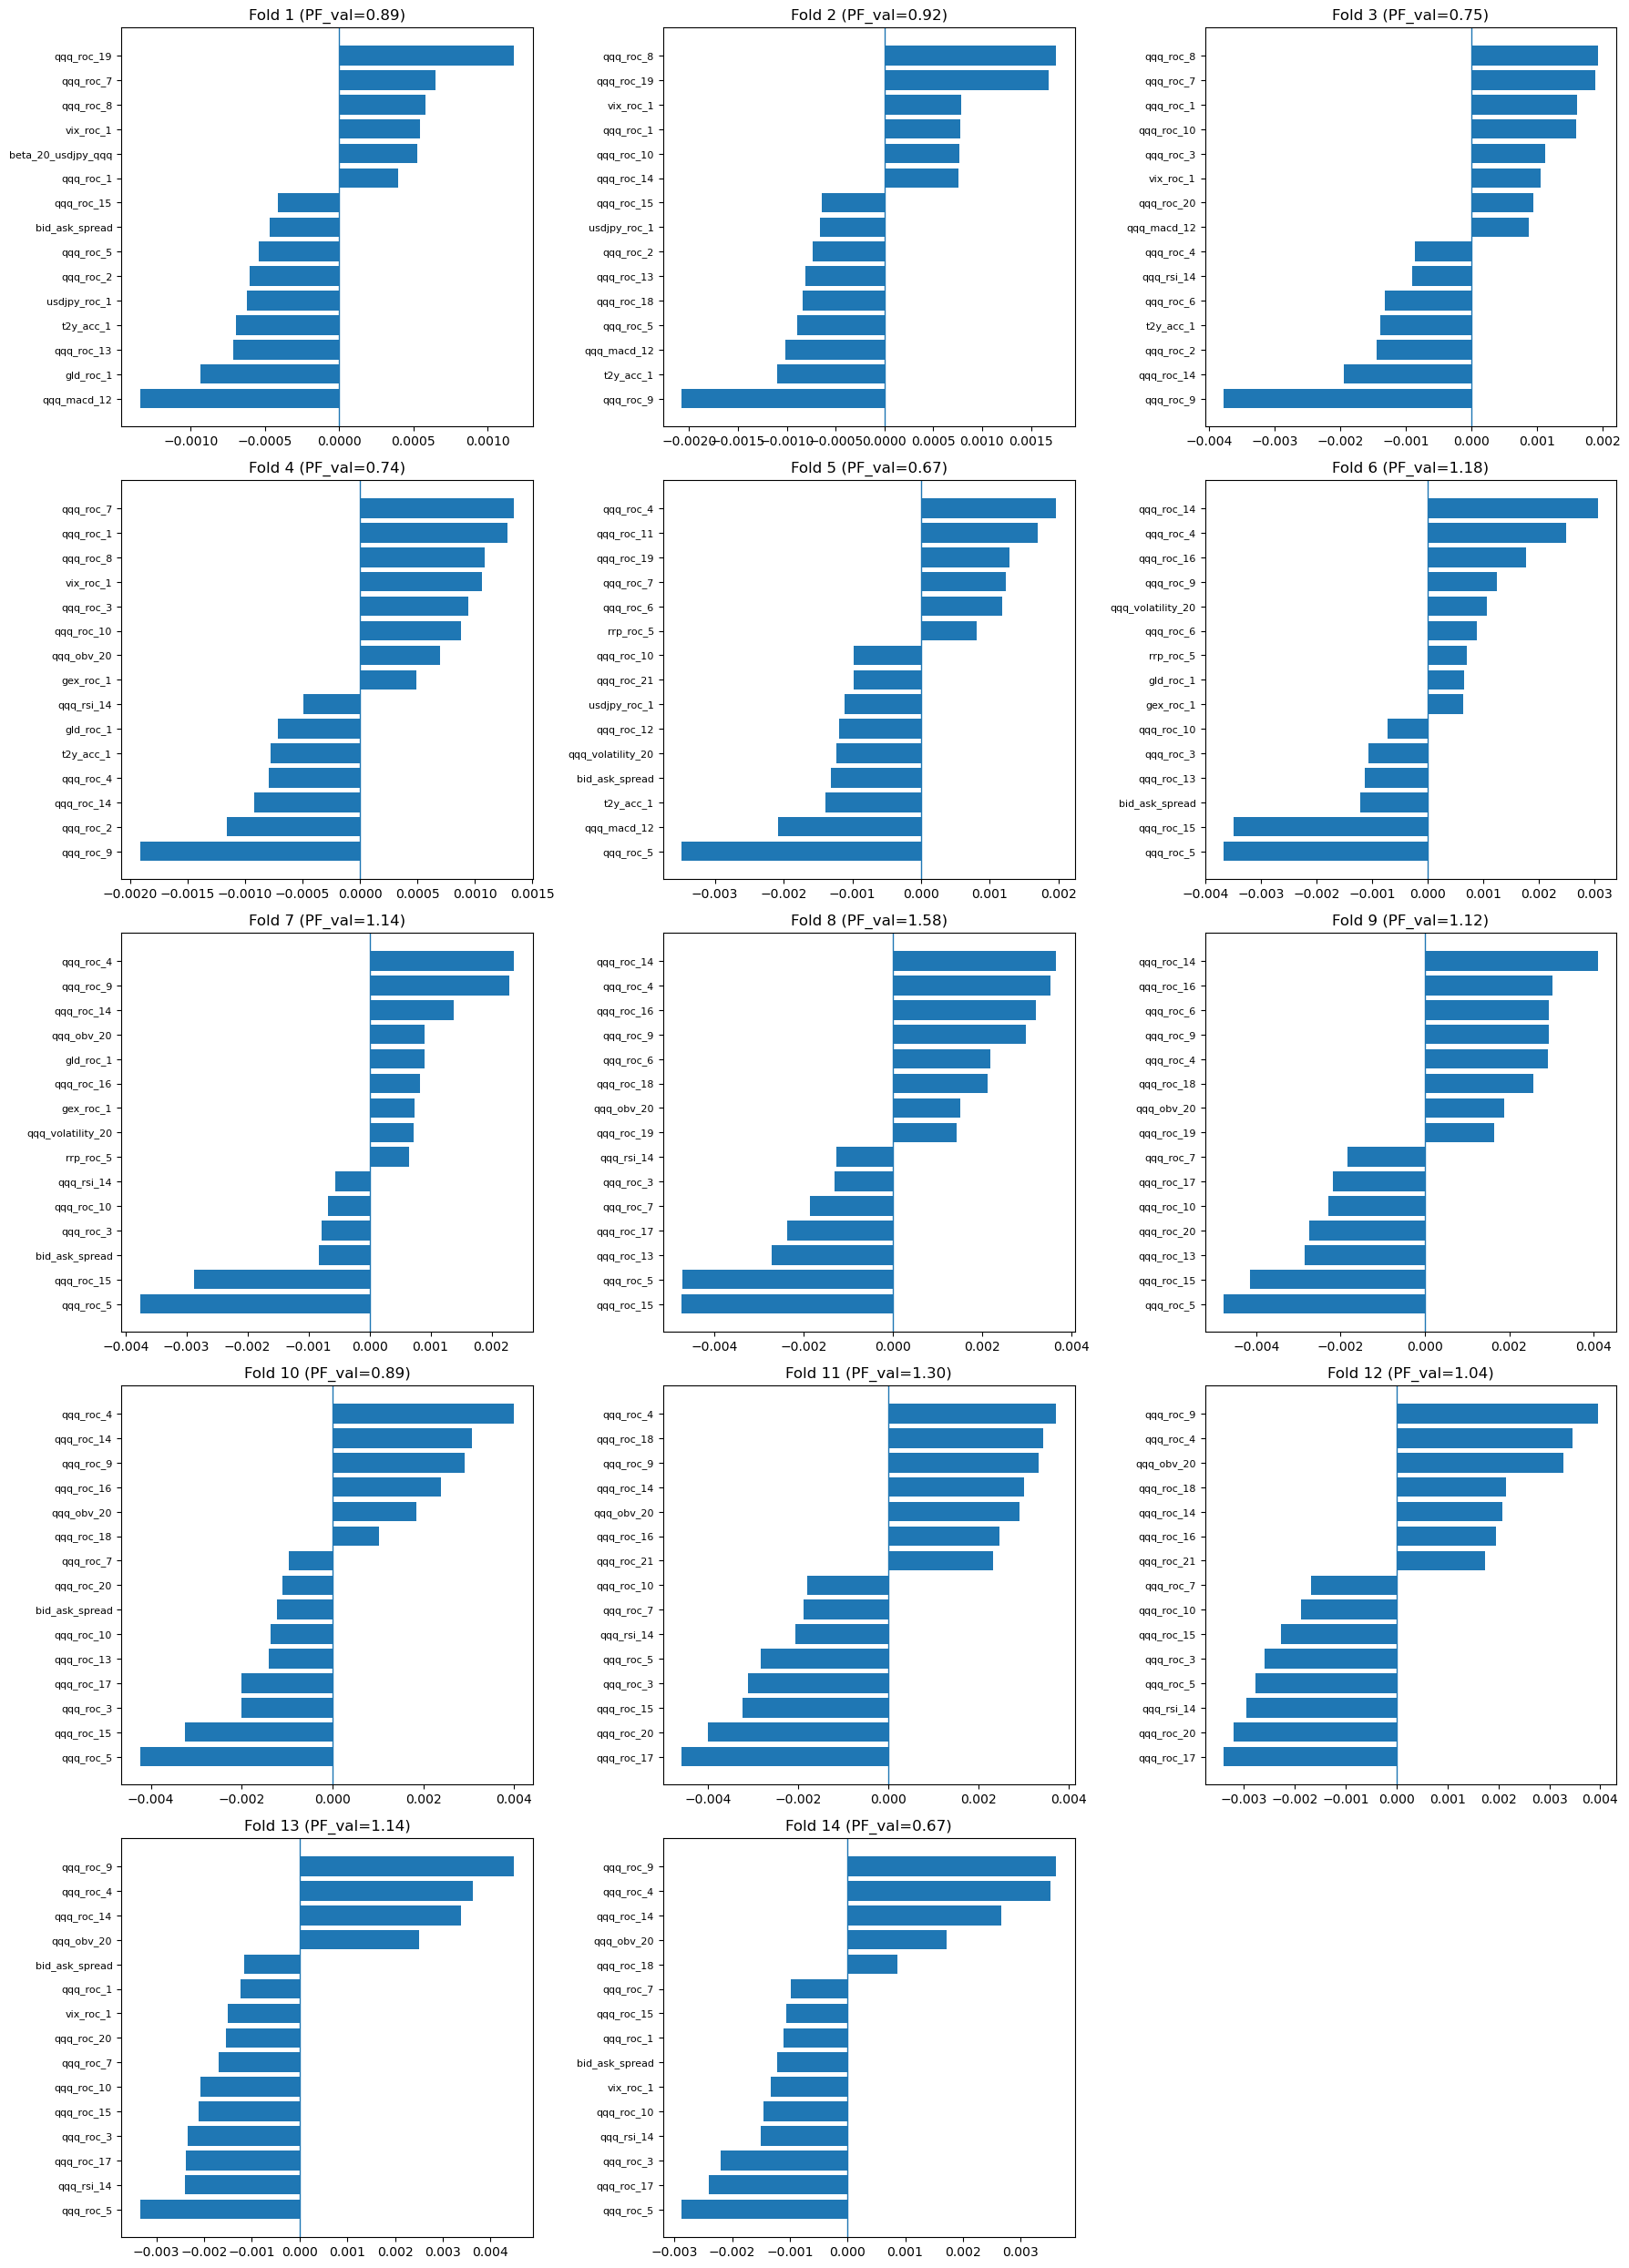

In [89]:
feature_names = get_preprocessed_feature_names(preprocess, X)

plot_coeffs_subplots(
    cv_res=cv_res,
    feature_names=feature_names,
    top_n=15,     # set None to plot all (can get crowded)
    ncols=3
)

In [90]:
top_x = 10
imp_df, in_top, top_presence, avg_imp, regime_compare = coeff_importance_summary(
    cv_res=cv_res,
    feature_names=feature_names,
    top_x=top_x,
    pre_folds=(0,1,2,3),
    post_folds=(4,5,6,7),
)

display(round_sigfig_df(top_presence, 3))
display(round_sigfig_df(avg_imp, 3))
display(round_sigfig_df(regime_compare, 3))

,top10_count,top10_frac
qqq_roc_9,12.0,0.8570
qqq_roc_4,11.0,0.7860
qqq_roc_5,11.0,0.7860
qqq_roc_14,10.0,0.7140
qqq_roc_3,9.0,0.6430
qqq_roc_15,8.0,0.5710
qqq_obv_20,6.0,0.4290
qqq_roc_13,6.0,0.4290
qqq_roc_17,6.0,0.4290
qqq_roc_16,5.0,0.3570


,avg_importance,median_importance,std_importance
qqq_roc_5,0.002750,0.003110,0.001610
qqq_roc_9,0.002560,0.002930,0.001340
qqq_roc_4,0.002370,0.002700,0.001420
qqq_roc_14,0.002180,0.002370,0.001290
qqq_roc_15,0.002120,0.002200,0.001540
qqq_roc_17,0.001440,0.001190,0.001510
qqq_obv_20,0.001420,0.001210,0.000973
qqq_roc_3,0.001410,0.001170,0.000907
qqq_roc_10,0.001260,0.001270,0.000634
qqq_roc_16,0.001200,0.000712,0.001210


,pre_mean_imp,post_mean_imp,delta_post_minus_pre,ratio_post_over_pre,pre_top10_frac,post_top10_frac,delta_top10_frac
qqq_roc_5,0.000494,0.003910,0.003420,7.920,0.25,1.00,0.75
qqq_roc_15,0.000410,0.002970,0.002560,7.260,0.00,0.75,0.75
qqq_roc_4,0.000417,0.002580,0.002170,6.190,0.25,1.00,0.75
qqq_roc_16,0.000011,0.001580,0.001570,145.000,0.00,0.75,0.75
qqq_roc_14,0.000905,0.002140,0.001240,2.370,0.50,0.75,0.25
qqq_volatility_20,0.000107,0.000908,0.000801,8.490,0.00,0.50,0.50
qqq_roc_6,0.000510,0.001140,0.000631,2.240,0.25,0.25,0.00
qqq_roc_17,0.000105,0.000712,0.000607,6.760,0.00,0.25,0.25
bid_ask_spread,0.000518,0.001050,0.000532,2.030,0.00,0.75,0.75
qqq_roc_11,0.000085,0.000576,0.000491,6.800,0.00,0.25,0.25


Feature Importance & Market Regime Analysis
A longitudinal analysis of feature importance across all folds reveals a clear regime shift between the Pre-COVID (Folds 1–5) and Post-COVID (Fold 6+) environments.

1. Pre-COVID Regime (Folds 1–5): Short-Term Dominance
During the Pre-COVID period, the model exhibited lower overall predictive power, with the top 10 feature importance values ranging from 0.00072 to 0.00178.

Core Features: The model consistently relied on very short-term indicators such as qqq_roc_2, qqq_roc_8, and macro-driven features like t2y_acc_1.

Stability: Features like qqq_roc_9 and qqq_roc_1 were present in the top 10 approximately 75% of the time, suggesting a relatively stable but weak predictive environment.

2. Post-COVID Regime (Fold 6+): Mid-Term Shift
Following the COVID-19 market crash, the "rules" governing price action shifted significantly. The top 10 feature importance values increased to a range of 0.00092 to 0.00386, nearly doubling the predictive weight of leading indicators.

Predictive Decay: Previous staples like qqq_roc_8 and qqq_roc_1 vanished from the top rankings, indicating their predictive signals had decayed or been rendered "noisy" by the new regime.

Mid-Term Emergence: The model pivoted toward mid-term features. qqq_roc_4 and qqq_roc_15, which were statistically insignificant Pre-COVID, became dominant, appearing in the top 10 list in 100% and 75% of the Post-COVID folds, respectively.

3. Conclusion
The data confirms a fundamental change in market microstructure. The Pre-COVID market was driven by short-term signals, whereas the Post-COVID market required a transition to mid-term trend indicators to maintain predictive accuracy. This temporal instability explains why a model trained exclusively on Pre-COVID data would likely fail in the current high-volatility environment.

# Why Fold 8 Holds While Fold 14 Collapses

In [91]:
#check convariate shift for fold14
fold14_train = ("2019-10-07", "2024-05-15")
fold14_test = ("2024-05-16", "2024-10-30")
drift_report = check_distribution_shift(X, fold14_train, fold14_test)
drift_report

,feature,ks_stat,p_value,is_drifted
38,beta_20_usdjpy_qqq,0.420,5.719725e-15,True
36,beta_20_gld_qqq,0.420,5.719725e-15,True
24,qqq_obv_20,0.274,1.691126e-06,True
39,bid_ask_spread,0.263,5.135321e-06,True
40,qqq_us2y_corr,0.249,1.969789e-05,True
26,gex_roc_1,0.238,5.366635e-05,True
23,qqq_volatility_20,0.229,1.176520e-04,True
1,qqq_macd_12,0.219,2.712582e-04,True
28,rrp_roc_5,0.205,8.188040e-04,True
37,beta_20_gbpusd_qqq,0.182,4.274121e-03,True


In [92]:
#check convariate shift for fold8
fold8_train = ("2016-12-29", "2021-08-10")
fold8_test = ("2021-08-11", "2022-01-31")
drift_report = check_distribution_shift(X, fold8_train, fold8_test)
drift_report

,feature,ks_stat,p_value,is_drifted
28,rrp_roc_5,0.386,1.222603e-12,True
37,beta_20_gbpusd_qqq,0.369,1.472910e-11,True
39,bid_ask_spread,0.284,5.907808e-07,True
40,qqq_us2y_corr,0.271,2.300447e-06,True
38,beta_20_usdjpy_qqq,0.258,8.374174e-06,True
14,qqq_roc_13,0.257,9.223628e-06,True
16,qqq_roc_15,0.252,1.486388e-05,True
22,qqq_roc_21,0.248,2.161927e-05,True
13,qqq_roc_12,0.244,3.124811e-05,True
15,qqq_roc_14,0.240,4.488359e-05,True


In [93]:
#concept drift analysis for fold14
fold14_features = [
    'qqq_roc_9', 'qqq_roc_4', 'qqq_roc_14',
    'qqq_obv_20', 'usdjpy_roc_1', 'qqq_roc_15',
    'qqq_roc_7', 'qqq_roc_1', 'bid_ask_spread',
    'vix_roc_1', 'qqq_roc_10', 'qqq_rsi_14',
    'qqq_roc_3', 'qqq_roc_17', 'qqq_roc_5'
]

concept_drift14 = analyze_correlation_drift(X, y, fold14_train, fold14_test, fold14_features)
concept_drift14

,corr_train,corr_test,corr_diff,abs_corr_diff,sign_flip
qqq_roc_9,0.024084,-0.114311,-0.138395,0.138395,True
qqq_roc_4,-0.039191,0.104362,0.143554,0.143554,True
qqq_roc_14,-0.006046,-0.206421,-0.200375,0.200375,False
qqq_obv_20,0.016129,-0.266859,-0.282987,0.282987,True
usdjpy_roc_1,-0.037301,-0.008761,0.028540,0.028540,False
qqq_roc_15,-0.011806,-0.142094,-0.130288,0.130288,False
qqq_roc_7,-0.035478,0.048365,0.083843,0.083843,True
qqq_roc_1,-0.071219,-0.077012,-0.005793,0.005793,False
bid_ask_spread,-0.056338,-0.090678,-0.034340,0.034340,False
vix_roc_1,0.015283,0.140978,0.125695,0.125695,False


In [94]:
#Check concept drift for fold 8
fold8_features = [
    'qqq_roc_14', 'qqq_roc_16', 'qqq_roc_6',
    'qqq_roc_9', 'qqq_roc_4', 'qqq_roc_18',
    'qqq_roc_20', 'qqq_roc_19', 'qqq_roc_7',
    'qqq_roc_17', 'qqq_roc_10', 'qqq_roc_20',
    'qqq_roc_13', 'qqq_roc_15', 'qqq_roc_5'
]
concept_drift8 = analyze_correlation_drift(X, y, fold8_train, fold8_test, fold8_features)
concept_drift8

,corr_train,corr_test,corr_diff,abs_corr_diff,sign_flip
qqq_roc_14,-0.038278,0.010141,0.048419,0.048419,True
qqq_roc_16,-0.015231,-0.028083,-0.012852,0.012852,False
qqq_roc_6,-0.045011,0.024506,0.069517,0.069517,True
qqq_roc_9,-0.003193,-0.072583,-0.069390,0.069390,False
qqq_roc_4,-0.057421,-0.044884,0.012537,0.012537,False
qqq_roc_18,-0.003977,-0.064470,-0.060494,0.060494,False
qqq_roc_20,-0.013526,-0.158332,-0.144806,0.144806,False
qqq_roc_19,-0.012745,-0.108335,-0.095590,0.095590,False
qqq_roc_7,-0.033073,-0.047813,-0.014740,0.014740,False
qqq_roc_17,-0.012714,-0.046853,-0.034138,0.034138,False


In [95]:
print("--------------------------------")
print("Fold 8")
print(f"Average absolute change in correlation: {concept_drift8['corr_diff'].abs().mean():.4f}")
print(f"Maximum absolute change in correlation: {concept_drift8['corr_diff'].abs().max():.4f}")
print(f"Number of features with sign flip: {concept_drift8['sign_flip'].sum()}")
print("--------------------------------")
print("Fold 14")
print(f"Average absolute change in correlation: {concept_drift14['corr_diff'].abs().mean():.4f}")
print(f"Maximum absolute change in correlation: {concept_drift14['corr_diff'].abs().max():.4f}")
print(f"Number of features with sign flip: {concept_drift14['sign_flip'].sum()}")

--------------------------------
Fold 8
Average absolute change in correlation: 0.0608
Maximum absolute change in correlation: 0.1448
Number of features with sign flip: 3
--------------------------------
Fold 14
Average absolute change in correlation: 0.1227
Maximum absolute change in correlation: 0.2830
Number of features with sign flip: 6


Comparative Analysis: Concept Drift vs. Covariate Shift
To diagnose the performance degradation in Fold 14 relative to Fold 8, a multi-layered analysis was conducted to distinguish between changes in input distributions (Covariate Shift) and changes in feature-target relationships (Concept Drift).

1. Distributional Stability (Covariate Shift)We performed a two-sample Kolmogorov-Smirnov (KS) test on the top 15 features to identify shifts in underlying distributions between training and test sets ($p < 0.05$).
Fold 8: Despite 14 out of 15 features exhibiting significant covariate shift, the model maintained relatively stable performance.
Fold 14: In contrast, only 2 out of 15 features showed signs of covariate shift, yet the model’s performance degraded significantly.

2. Relationship Stability (Concept Drift)
While Fold 14 demonstrated higher distributional stability, it suffered from extreme instability in its predictive relationships:

Correlation Volatility: Fold 14 exhibited a mean correlation change of 0.11, more than double the 0.0535 observed in Fold 8.

Sign Flip Severity: For features experiencing a directional reversal (sign flip), the average absolute change in correlation in Fold 14 was 0.1274, nearly triple the 0.04637 seen in Fold 8.

3. Conclusion
The data confirms that performance degradation in this model is primarily driven by concept drift rather than covariate shift. Fold 8 proves that the model can generalize even when feature distributions change. However, in Fold 14, the fundamental "rules" of the market shifted—where the direction and strength of feature-target relationships were disrupted—leading to the observed loss in predictive power.

# Analyze MDD in post-covid period

The model shows a contiuous loss from 2025-03-27 to 2020-08-31, which occurs at about period of fold 5. The The -35.1% mdd occurs on 2020-08-31 as well.

In [96]:
#check convariate shift for fold5
fold5_train = ("2015-08-07", " 2020-03-31")
fold5_test = ("2020-04-01", "2020-09-03")
drift_report = check_distribution_shift(X, fold5_train, fold5_test)
drift_report

,feature,ks_stat,p_value,is_drifted
1,qqq_macd_12,0.896,2.918850e-84,True
23,qqq_volatility_20,0.642,1.569235e-36,True
22,qqq_roc_21,0.635,1.182943e-35,True
20,qqq_roc_19,0.620,7.987186e-34,True
21,qqq_roc_20,0.616,2.392816e-33,True
19,qqq_roc_18,0.591,1.791620e-30,True
38,beta_20_usdjpy_qqq,0.590,2.315205e-30,True
16,qqq_roc_15,0.588,3.858854e-30,True
17,qqq_roc_16,0.576,7.853029e-29,True
15,qqq_roc_14,0.558,6.122647e-27,True


Among the top 15 features, 14 of them has a covariate shift

In [97]:
#Check concept drift for fold 5
fold5_features = [
    'qqq_roc_4', 'qqq_roc_11', 'qqq_roc_7',
    'qqq_roc_19', 'qqq_roc_6', 'rrp_roc_5',
    'qqq_roc_10', 'qqq_roc_21', 'usdjpy_roc_1',
    'qqq_roc_12', 'qqq_volatility_20', 'bid_ask_spread',
    't2y_acc_1', 'qqq_macd_12', 'qqq_roc_5'
]

concept_drift5 = analyze_correlation_drift(X, y, fold5_train, fold5_test, fold5_features)
concept_drift5

,corr_train,corr_test,corr_diff,abs_corr_diff,sign_flip
qqq_roc_4,-0.042563,-0.192415,-0.149853,0.149853,False
qqq_roc_11,-0.034253,-0.126985,-0.092732,0.092732,False
qqq_roc_7,0.002084,-0.222586,-0.224670,0.224670,True
qqq_roc_19,-0.013531,-0.218566,-0.205035,0.205035,False
qqq_roc_6,-0.002286,-0.231047,-0.228761,0.228761,False
rrp_roc_5,-0.045241,0.175404,0.220645,0.220645,True
qqq_roc_10,-0.044984,-0.186799,-0.141814,0.141814,False
qqq_roc_21,-0.019197,-0.174605,-0.155408,0.155408,False
usdjpy_roc_1,-0.072883,0.071527,0.144410,0.144410,True
qqq_roc_12,-0.040172,-0.130045,-0.089873,0.089873,False


In [98]:
sr = strtegy_ret.loc[fold5_test[0]:fold5_test[1]]

print("Fold 5")
print(f"Average absolute change in correlation: {concept_drift5['corr_diff'].abs().mean():.4f}")
print(f"Maximum absolute change in correlation: {concept_drift5['corr_diff'].abs().max():.4f}")
print(f"Number of features with sign flip: {concept_drift5['sign_flip'].sum()}")
print(f"Win rate: {len(sr[sr > 0]) / len(sr):.4f}")
print(f"mean return: {sr.mean():.4f}")

Fold 5
Average absolute change in correlation: 0.1646
Maximum absolute change in correlation: 0.2773
Number of features with sign flip: 4
Win rate: 0.4100
mean return: -0.0028


Upon evaluating Fold 5, a significant discrepancy in feature-target relationships was observed between the training and validation periods, indicating substantial concept drift.

Correlation Instability: Feature correlations underwent drastic shifts; for instance, qqq_roc_4 moved from -0.0426 in training to -0.192 in the test set.

Directional Shifts (Sign Flips): A total of 4 features experienced a "sign flip," where the direction of the relationship with the target completely reversed.

Drift Impact: The average absolute change in correlation reached 0.1646. This suggests that the market regime shifted into a state where these technical indicators became significantly more volatile or predictive than the model anticipated during training.

Strategy Outcomes: This drift directly contributed to a degraded Win Rate of 0.41 and a negative mean return, as the model's weights were optimized for a lower-correlation environment.